# Trabajo Práctico 3

# Imports y función de entrenamiento

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, zero_one_loss, accuracy_score
from sklearn.model_selection import train_test_split
import copy
import math
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.naive_bayes import CategoricalNB

warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [40]:
#función que entrena una red ya definida previamente "evaluaciones" veces, cada vez entrenando un número de épocas elegido al crear la red y midiendo el error en train, validación y test al terminar ese paso de entrenamiento.
#Guarda y devuelve la red en el paso de evaluación que da el mínimo error de validación
#entradas: la red, las veces que evalua, los datos de entrenamiento y sus respuestas, de validacion y sus respuestas, de test y sus respuestas
#salidas: la red entrenada en el mínimo de validación, los errores de train, validación y test medidos en cada evaluación
def entrenar_red(red, evaluaciones, X_train, y_train, X_val, y_val, X_test, y_test):
    if type(red) == MLPRegressor:
      error_fun = mean_squared_error
    else:
      error_fun = zero_one_loss

    best_red = red
    best_red_error = 1.0
    error_train = []
    error_val = []
    error_test = []

    for i in range(evaluaciones):
      red.fit(X_train, y_train)

      P_train = red.predict(X_train)
      error_train.append(error_fun(y_train, P_train))

      P_val = red.predict(X_val)
      red_error_val = error_fun(y_val, P_val)
      error_val.append(red_error_val)

      P_test = red.predict(X_test)
      error_test.append(error_fun(y_test, P_test))

      if red_error_val < best_red_error:
        best_red = copy.deepcopy(red)
        best_red_error = red_error_val

    return best_red, error_train, error_val, error_test

In [41]:
def entrenar_red_weight_decay(red, evaluaciones, X_train, y_train, X_test, y_test, weight_fun = np.square):
    if type(red) == MLPRegressor:
      error_fun = mean_squared_error
    else:
      error_fun = zero_one_loss

    error_train = []
    error_test = []
    weight_sum = []

    for i in range(evaluaciones):
      red.fit(X_train, y_train)

      P_train = red.predict(X_train)
      error_train.append(error_fun(y_train, P_train))

      P_test = red.predict(X_test)
      error_test.append(error_fun(y_test, P_test))

      weight_sum.append(np.sum([np.sum(weight_fun(w)) for w in red.coefs_]))

    return red, error_train, error_test, weight_sum

In [42]:
def cargar_csv(path, xcols=2, delim_whitespace=False):
    """
    Argumentos:
      path (str): ruta al archivo csv a cargar
      xcols (int): cantidad de columnas que representan las entradas,
        la columna restante representara la clase o dato de salida
    """
    df = pd.read_csv(path, delim_whitespace=delim_whitespace, header=None)
    X = df.loc[:, 0:(xcols-1)]
    y = df.loc[:, xcols]
    return X,y

In [43]:
def cartesian_to_polar(x, y):
    rho = (x**2 + y**2)**0.5
    theta = math.atan2(y, x)
    return rho, theta

def is_inside_curve(rho, theta, npi):
  rho_curve1 = (theta + (npi-1)*math.pi) / (4 * math.pi)
  rho_curve2 = (theta + npi*math.pi) / (4 * math.pi)
  return rho_curve1 <= rho <= rho_curve2

def is_inside_curves(x, y):
    rho, theta = cartesian_to_polar(x, y)
    return is_inside_curve(rho, theta, 1) or is_inside_curve(rho, theta, 3) or is_inside_curve(rho, theta, 5)

def espirales(n):
  count0 = 0
  count1 = 0
  l = []
  while (count0 + count1) < n:
    x = np.random.uniform(-1, 1, 1)
    y = np.random.uniform(-1, 1, 1)
    if ((x**2 + y**2)**0.5 < 1): # si esta adentro del circulo
      if (is_inside_curves(x, y)):
        if count0 < int(n/2):
          l.append([x, y, 0])
          count0+=1
      else:
        if count1 < int(n/2):
          l.append([x, y, 1])
          count1+=1
  df = pd.DataFrame(l, columns=['dim_1', 'dim_2', 'class'])
  return df

# Ejercicio 1

## Funciones de generación

In [44]:
def covM(d, C):
  return np.identity(d)*([(C*np.sqrt(d))**2]*d)

def diagonales(n, d, C):
  n0 = int(n/2)
  #Clase0
  c0 = [np.append(x, 0) for x in np.random.multivariate_normal([-1]*d, covM(d, C), n0)]
  #Clase1
  c1 = [np.append(x, 1) for x in np.random.multivariate_normal([1]*d, covM(d, C), n-n0)]

  flist = c0 + c1
  # Crear DataFrame
  df = pd.DataFrame(flist, columns=[f'dim_{i}' for i in range(d)] + ['class'])
  return df

def covM2(d, C):
  return np.identity(d)*([C**2]*d)

def paralelas(n, d, C):
  n0 = int(n/2)
  #Clase0
  c0 = [np.append(x, 0) for x in np.random.multivariate_normal([-1] + [0]*(d-1), covM2(d, C), n0)]
  #Clase1
  c1 = [np.append(x, 1) for x in np.random.multivariate_normal([1] + [0]*(d-1), covM2(d, C), n-n0)]

  flist = c0 + c1
  # Crear DataFrame
  df = pd.DataFrame(flist, columns=[f'dim_{i}' for i in range(d)] + ['class'])
  return df

## Valores generales

In [45]:
C = 0.78
n_training = 250
n_testing = 10000
d_values = [2, 4, 8, 16, 32]
count_for_avg = 20

#defino parámetros de la red
epocas_por_entrenamiento=50     #numero de epocas que entrena cada vez
eta=0.1                         #learning rate
alfa=0.9                        #momentum
evaluaciones = 400
gamma = 0.0001
N2 = 6

## Entrenamiento

### Diagonales

In [46]:
errors_diagonales_trees = {}
errors_diagonales_redes = {}
errors_diagonales_naive_bayes = {}

for d in d_values:
  errors_list_trees = []
  errors_list_redes = []
  errors_list_naive_bayes = []

  df_test = diagonales(n_testing, d, C)
  y_test = df_test["class"].to_numpy()
  X_test = df_test.drop(columns=["class"]).to_numpy()

  for i in range(count_for_avg):
    print(f"Diagonales, d={d}, iteración={i}")
    df_train = diagonales(n_training, d, C)
    y_train = df_train["class"].to_numpy()
    X_train = df_train.drop(columns=["class"]).to_numpy()

    # Naive Bayes
    clf = GaussianNB()
    clf.fit(X_train, y_train)

    predict_test = clf.predict(X_test)
    accuracy_test = accuracy_score(y_test, predict_test)

    predict_train = clf.predict(X_train)
    accuracy_train = accuracy_score(y_train, predict_train)

    errors_list_naive_bayes.append({'error_test': 1-accuracy_test, 'error_train': 1-accuracy_train})

    # Redes
    clasif = MLPClassifier(hidden_layer_sizes=(N2,), activation='logistic', solver='sgd', alpha=gamma, batch_size=1, learning_rate='constant', learning_rate_init=eta,momentum=alfa,nesterovs_momentum=False,tol=0.0,warm_start=True,max_iter=epocas_por_entrenamiento)

    best_red, error_train, error_test, _ = entrenar_red_weight_decay(clasif, evaluaciones, X_train, y_train, X_test, y_test)

    errors_list_redes.append({'error_test': error_test[-1], 'error_train': error_train[-1]})

    # Árboles
    t = DecisionTreeClassifier(criterion="entropy",min_impurity_decrease=0.002,random_state=0,min_samples_leaf=5)
    t.fit(X_train, y_train)

    predict_test = t.predict(X_test)
    accuracy_test = accuracy_score(y_test, predict_test)

    predict_train = t.predict(X_train)
    accuracy_train = accuracy_score(y_train, predict_train)

    errors_list_trees.append({'error_test': 1-accuracy_test, 'error_train': 1-accuracy_train})

  errors_diagonales_redes[d] = errors_list_redes
  errors_diagonales_trees[d] = errors_list_trees
  errors_diagonales_naive_bayes[d] = errors_list_naive_bayes

Diagonales, d=2, iteración=0
Diagonales, d=2, iteración=1
Diagonales, d=2, iteración=2
Diagonales, d=2, iteración=3
Diagonales, d=2, iteración=4
Diagonales, d=2, iteración=5
Diagonales, d=2, iteración=6
Diagonales, d=2, iteración=7
Diagonales, d=2, iteración=8
Diagonales, d=2, iteración=9
Diagonales, d=2, iteración=10
Diagonales, d=2, iteración=11
Diagonales, d=2, iteración=12
Diagonales, d=2, iteración=13
Diagonales, d=2, iteración=14
Diagonales, d=2, iteración=15
Diagonales, d=2, iteración=16
Diagonales, d=2, iteración=17
Diagonales, d=2, iteración=18
Diagonales, d=2, iteración=19
Diagonales, d=4, iteración=0
Diagonales, d=4, iteración=1
Diagonales, d=4, iteración=2
Diagonales, d=4, iteración=3
Diagonales, d=4, iteración=4
Diagonales, d=4, iteración=5
Diagonales, d=4, iteración=6
Diagonales, d=4, iteración=7
Diagonales, d=4, iteración=8
Diagonales, d=4, iteración=9
Diagonales, d=4, iteración=10
Diagonales, d=4, iteración=11
Diagonales, d=4, iteración=12
Diagonales, d=4, iteración=13


In [47]:
errors_test_diagonales_tree_avg = []
errors_train_diagonales_tree_avg = []
for k, l in errors_diagonales_trees.items():
  sum_train = 0
  sum_test = 0
  for e in l:
    sum_train += e['error_train']
    sum_test += e['error_test']
  errors_test_diagonales_tree_avg.append(sum_test/count_for_avg)
  errors_train_diagonales_tree_avg.append(sum_train/count_for_avg)

errors_test_diagonales_red_avg = []
errors_train_diagonales_red_avg = []
for k, l in errors_diagonales_redes.items():
  sum_train = 0
  sum_test = 0
  for e in l:
    sum_train += e['error_train']
    sum_test += e['error_test']
  errors_test_diagonales_red_avg.append(sum_test/count_for_avg)
  errors_train_diagonales_red_avg.append(sum_train/count_for_avg)

errors_test_diagonales_naive_bayes_avg = []
errors_train_diagonales_naive_bayes_avg = []
for k, l in errors_diagonales_naive_bayes.items():
  sum_train = 0
  sum_test = 0
  for e in l:
    sum_train += e['error_train']
    sum_test += e['error_test']
  errors_test_diagonales_naive_bayes_avg.append(sum_test/count_for_avg)
  errors_train_diagonales_naive_bayes_avg.append(sum_train/count_for_avg)

### Paralelas

In [48]:
errors_paralelas_redes = {}
errors_paralelas_trees = {}
errors_paralelas_naive_bayes = {}

for d in d_values:
  errors_list_trees = []
  errors_list_redes = []
  errors_list_naive_bayes = []

  df_test = paralelas(n_testing, d, C)
  y_test = df_test["class"].to_numpy()
  X_test = df_test.drop(columns=["class"]).to_numpy()

  for i in range(count_for_avg):
    print(f"Paralelas, d={d}, iteración={i}")
    df_train = paralelas(n_training, d, C)
    y_train = df_train["class"].to_numpy()
    X_train = df_train.drop(columns=["class"]).to_numpy()

    # Naive Bayes
    clf = GaussianNB()
    clf.fit(X_train, y_train)

    predict_test = clf.predict(X_test)
    accuracy_test = accuracy_score(y_test, predict_test)

    predict_train = clf.predict(X_train)
    accuracy_train = accuracy_score(y_train, predict_train)

    errors_list_naive_bayes.append({'error_test': 1-accuracy_test, 'error_train': 1-accuracy_train})

    # Redes
    clasif = MLPClassifier(hidden_layer_sizes=(N2,), activation='logistic', solver='sgd', alpha=gamma, batch_size=1, learning_rate='constant', learning_rate_init=eta,momentum=alfa,nesterovs_momentum=False,tol=0.0,warm_start=True,max_iter=epocas_por_entrenamiento)

    best_red, error_train, error_test, _ = entrenar_red_weight_decay(clasif, evaluaciones, X_train, y_train, X_test, y_test)

    errors_list_redes.append({'error_test': error_test[-1], 'error_train': error_train[-1]})

    # Árboles
    t = DecisionTreeClassifier(criterion="entropy",min_impurity_decrease=0.002,random_state=0,min_samples_leaf=5)
    t.fit(X_train, y_train)

    predict_test = t.predict(X_test)
    accuracy_test = accuracy_score(y_test, predict_test)

    predict_train = t.predict(X_train)
    accuracy_train = accuracy_score(y_train, predict_train)

    errors_list_trees.append({'error_test': 1-accuracy_test, 'error_train': 1-accuracy_train})
  
  errors_paralelas_redes[d] = errors_list_redes
  errors_paralelas_trees[d] = errors_list_trees
  errors_paralelas_naive_bayes[d] = errors_list_naive_bayes

Paralelas, d=2, iteración=0
Paralelas, d=2, iteración=1
Paralelas, d=2, iteración=2
Paralelas, d=2, iteración=3
Paralelas, d=2, iteración=4
Paralelas, d=2, iteración=5
Paralelas, d=2, iteración=6
Paralelas, d=2, iteración=7
Paralelas, d=2, iteración=8
Paralelas, d=2, iteración=9
Paralelas, d=2, iteración=10
Paralelas, d=2, iteración=11
Paralelas, d=2, iteración=12
Paralelas, d=2, iteración=13
Paralelas, d=2, iteración=14
Paralelas, d=2, iteración=15
Paralelas, d=2, iteración=16
Paralelas, d=2, iteración=17
Paralelas, d=2, iteración=18
Paralelas, d=2, iteración=19
Paralelas, d=4, iteración=0
Paralelas, d=4, iteración=1
Paralelas, d=4, iteración=2
Paralelas, d=4, iteración=3
Paralelas, d=4, iteración=4
Paralelas, d=4, iteración=5
Paralelas, d=4, iteración=6
Paralelas, d=4, iteración=7
Paralelas, d=4, iteración=8
Paralelas, d=4, iteración=9
Paralelas, d=4, iteración=10
Paralelas, d=4, iteración=11
Paralelas, d=4, iteración=12
Paralelas, d=4, iteración=13
Paralelas, d=4, iteración=14
Paral

In [49]:
errors_test_paralelas_tree_avg = []
errors_train_paralelas_tree_avg = []
for k, l in errors_paralelas_trees.items():
  sum_train = 0
  sum_test = 0
  for e in l:
    sum_train += e['error_train']
    sum_test += e['error_test']
  errors_test_paralelas_tree_avg.append(sum_test/count_for_avg)
  errors_train_paralelas_tree_avg.append(sum_train/count_for_avg)

errors_test_paralelas_red_avg = []
errors_train_paralelas_red_avg = []
for k, l in errors_paralelas_redes.items():
  sum_train = 0
  sum_test = 0
  for e in l:
    sum_train += e['error_train']
    sum_test += e['error_test']
  errors_test_paralelas_red_avg.append(sum_test/count_for_avg)
  errors_train_paralelas_red_avg.append(sum_train/count_for_avg)

errors_test_paralelas_naive_bayes_avg = []
errors_train_paralelas_naive_bayes_avg = []
for k, l in errors_paralelas_naive_bayes.items():
  sum_train = 0
  sum_test = 0
  for e in l:
    sum_train += e['error_train']
    sum_test += e['error_test']
  errors_test_paralelas_naive_bayes_avg.append(sum_test/count_for_avg)
  errors_train_paralelas_naive_bayes_avg.append(sum_train/count_for_avg)

## Gráficas

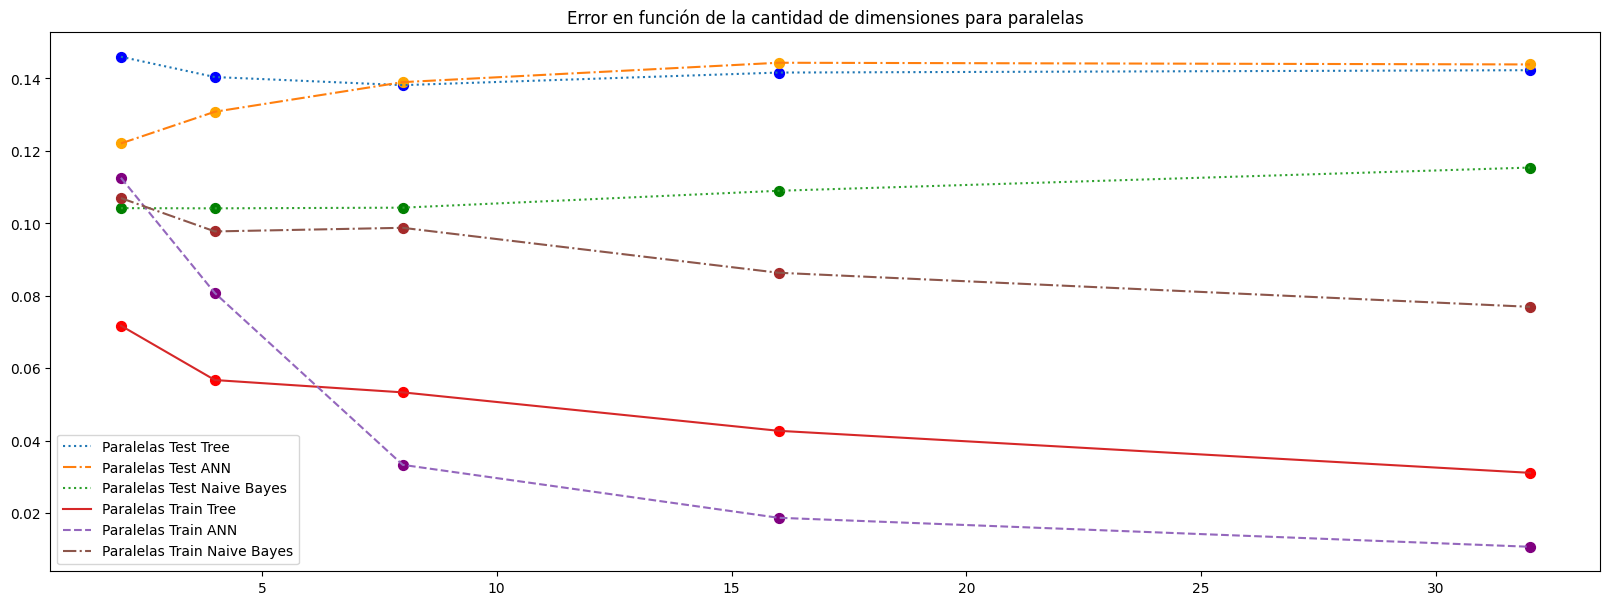

In [50]:
plt.figure(figsize=(20, 7))
plt.plot(d_values, errors_test_paralelas_tree_avg, label="Paralelas Test Tree", linestyle=":")
plt.plot(d_values, errors_test_paralelas_red_avg, label="Paralelas Test ANN", linestyle="-.")
plt.plot(d_values, errors_test_paralelas_naive_bayes_avg, label="Paralelas Test Naive Bayes", linestyle=":")
plt.plot(d_values, errors_train_paralelas_tree_avg, label="Paralelas Train Tree", linestyle="-")
plt.plot(d_values, errors_train_paralelas_red_avg, label="Paralelas Train ANN", linestyle="--")
plt.plot(d_values, errors_train_paralelas_naive_bayes_avg, label="Paralelas Train Naive Bayes", linestyle="-.")

plt.scatter(d_values, errors_test_paralelas_tree_avg, color='blue', s=50)  # puntos en azul
plt.scatter(d_values, errors_test_paralelas_red_avg, color='orange', s=50)  # puntos en naranja
plt.scatter(d_values, errors_test_paralelas_naive_bayes_avg, color='green', s=50)  # puntos en verde
plt.scatter(d_values, errors_train_paralelas_tree_avg, color='red', s=50)  # puntos en rojo
plt.scatter(d_values, errors_train_paralelas_red_avg, color='purple', s=50)  
plt.scatter(d_values, errors_train_paralelas_naive_bayes_avg, color='brown', s=50)  

plt.title(f'Error en función de la cantidad de dimensiones para paralelas')
plt.legend()
plt.show()

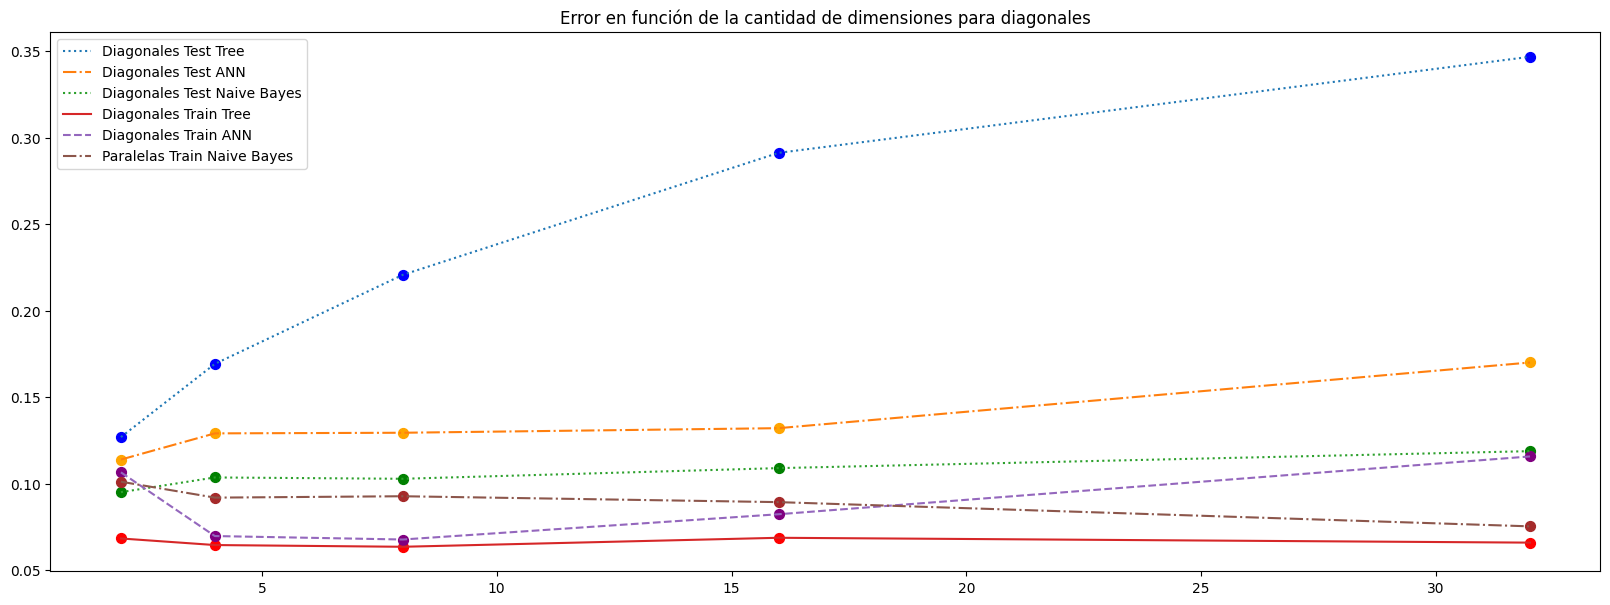

In [51]:
plt.figure(figsize=(20, 7))
plt.plot(d_values, errors_test_diagonales_tree_avg, label="Diagonales Test Tree", linestyle=":")
plt.plot(d_values, errors_test_diagonales_red_avg, label="Diagonales Test ANN", linestyle="-.")
plt.plot(d_values, errors_test_diagonales_naive_bayes_avg, label="Diagonales Test Naive Bayes", linestyle=":")
plt.plot(d_values, errors_train_diagonales_tree_avg, label="Diagonales Train Tree", linestyle="-")
plt.plot(d_values, errors_train_diagonales_red_avg, label="Diagonales Train ANN", linestyle="--")
plt.plot(d_values, errors_train_diagonales_naive_bayes_avg, label="Paralelas Train Naive Bayes", linestyle="-.")

plt.scatter(d_values, errors_test_diagonales_tree_avg, color='blue', s=50)  # puntos en azul
plt.scatter(d_values, errors_test_diagonales_red_avg, color='orange', s=50)  # puntos en naranja
plt.scatter(d_values, errors_test_diagonales_naive_bayes_avg, color='green', s=50)  # puntos en verde
plt.scatter(d_values, errors_train_diagonales_tree_avg, color='red', s=50)  # puntos en rojo
plt.scatter(d_values, errors_train_diagonales_red_avg, color='purple', s=50)  
plt.scatter(d_values, errors_train_diagonales_naive_bayes_avg, color='brown', s=50)  

plt.title(f'Error en función de la cantidad de dimensiones para diagonales')
plt.legend()
plt.show()

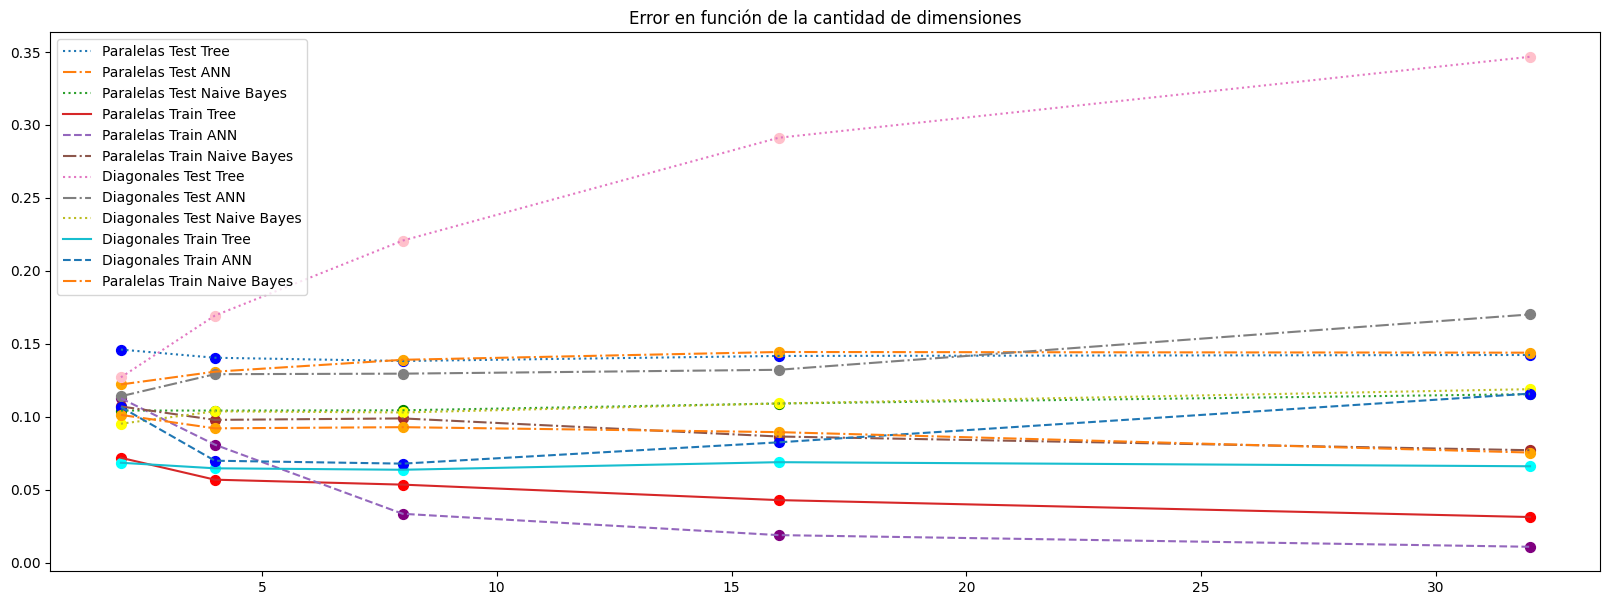

In [52]:
plt.figure(figsize=(20, 7))
plt.plot(d_values, errors_test_paralelas_tree_avg, label="Paralelas Test Tree", linestyle=":")
plt.plot(d_values, errors_test_paralelas_red_avg, label="Paralelas Test ANN", linestyle="-.")
plt.plot(d_values, errors_test_paralelas_naive_bayes_avg, label="Paralelas Test Naive Bayes", linestyle=":")
plt.plot(d_values, errors_train_paralelas_tree_avg, label="Paralelas Train Tree", linestyle="-")
plt.plot(d_values, errors_train_paralelas_red_avg, label="Paralelas Train ANN", linestyle="--")
plt.plot(d_values, errors_train_paralelas_naive_bayes_avg, label="Paralelas Train Naive Bayes", linestyle="-.")
plt.plot(d_values, errors_test_diagonales_tree_avg, label="Diagonales Test Tree", linestyle=":")
plt.plot(d_values, errors_test_diagonales_red_avg, label="Diagonales Test ANN", linestyle="-.")
plt.plot(d_values, errors_test_diagonales_naive_bayes_avg, label="Diagonales Test Naive Bayes", linestyle=":")
plt.plot(d_values, errors_train_diagonales_tree_avg, label="Diagonales Train Tree", linestyle="-")
plt.plot(d_values, errors_train_diagonales_red_avg, label="Diagonales Train ANN", linestyle="--")
plt.plot(d_values, errors_train_diagonales_naive_bayes_avg, label="Paralelas Train Naive Bayes", linestyle="-.")

plt.scatter(d_values, errors_test_paralelas_tree_avg, color='blue', s=50)  
plt.scatter(d_values, errors_test_paralelas_red_avg, color='orange', s=50)  
plt.scatter(d_values, errors_test_paralelas_naive_bayes_avg, color='green', s=50)  
plt.scatter(d_values, errors_train_paralelas_tree_avg, color='red', s=50) 
plt.scatter(d_values, errors_train_paralelas_red_avg, color='purple', s=50)  
plt.scatter(d_values, errors_train_paralelas_naive_bayes_avg, color='brown', s=50)  
plt.scatter(d_values, errors_test_diagonales_tree_avg, color='pink', s=50)
plt.scatter(d_values, errors_test_diagonales_red_avg, color='grey', s=50)  
plt.scatter(d_values, errors_test_diagonales_naive_bayes_avg, color='yellow', s=50)
plt.scatter(d_values, errors_train_diagonales_tree_avg, color='cyan', s=50)
plt.scatter(d_values, errors_train_diagonales_red_avg, color='blue', s=50)
plt.scatter(d_values, errors_train_diagonales_naive_bayes_avg, color='orange', s=50)

plt.title(f'Error en función de la cantidad de dimensiones')
plt.legend()
plt.show()

## Análisis



# Ejercicio 2

## Dos elipses

### Entrenamiento

In [53]:
X_data_aux, y_data_aux = cargar_csv("./data/dos_elipses.data", 2)
X_test, y_test = cargar_csv("./data/dos_elipses.test", 2)

X_data, _, y_data, _ = train_test_split(X_data_aux, y_data_aux, test_size = 0.5)
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size = 0.2)

C:\Users\Certi\AppData\Local\Temp\ipykernel_1956\1536466213.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(path, delim_whitespace=delim_whitespace, header=None)
C:\Users\Certi\AppData\Local\Temp\ipykernel_1956\1536466213.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(path, delim_whitespace=delim_whitespace, header=None)


In [54]:
#defino parámetros de la red
epocas_por_entrenamiento = 50     #numero de epocas que entrena cada vez
evaluaciones = 300
N2 = 6

alfa = 0.9
lr = 0.01
trys = 10

In [55]:
best_red = None
best_error = 1.0
for i in range(trys):
    clasif = MLPClassifier(hidden_layer_sizes=(N2,), activation='logistic', solver='sgd', alpha=0.0, batch_size=1, learning_rate='constant', learning_rate_init=lr,momentum=alfa,nesterovs_momentum=False,tol=0.0,warm_start=True,max_iter=epocas_por_entrenamiento)

    red, _, _, _ = entrenar_red(clasif, evaluaciones, X_train, y_train, X_val, y_val, X_test, y_test)
    
    P_test = red.predict(X_test)
    test_error = zero_one_loss(y_test, P_test)

    if test_error < best_error:
        best_error = test_error
        best_red = red

In [56]:
# Naive Bayes
naive_bayes = GaussianNB()
naive_bayes.fit(X_data, y_data)

GaussianNB()

### Gráficas

Error de ANN fue 0.015499999999999958


C:\Users\Certi\AppData\Local\Temp\ipykernel_1956\171257662.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(
C:\Users\Certi\AppData\Local\Temp\ipykernel_1956\171257662.py:16: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


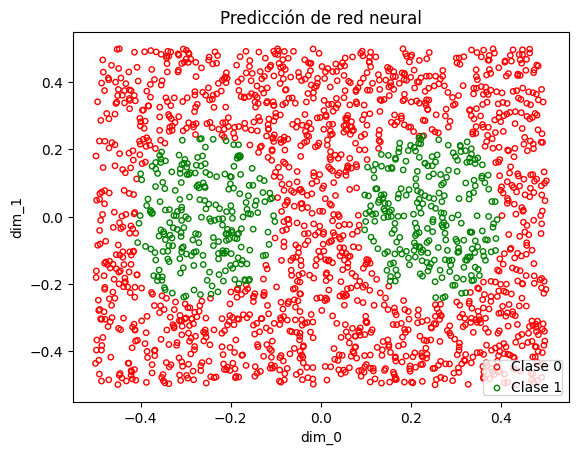

In [57]:
print(f"Error de ANN fue {best_error}")

prediction = best_red.predict(X_test)
idx = np.where(prediction == 0)
plt.scatter(
    X_test.to_numpy()[idx, 0],
    X_test.to_numpy()[idx, 1],
    facecolors='none',
    edgecolors='r',
    label="Clase 0",
    cmap=plt.cm.RdYlBu,
    s=15,
)

idx = np.where(prediction == 1)
plt.scatter(
    X_test.to_numpy()[idx, 0],
    X_test.to_numpy()[idx, 1],
    facecolors='none',
    edgecolors='g',
    label="Clase 1",
    cmap=plt.cm.RdYlBu,
    s=15,
)

plt.xlabel("dim_0")
plt.ylabel("dim_1")
plt.legend(loc="lower right", borderpad=0, handletextpad=0)
plt.title(f'Predicción de red neural')
plt.show()

Error de ANN fue 0.241


C:\Users\Certi\AppData\Local\Temp\ipykernel_1956\2709270753.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(
C:\Users\Certi\AppData\Local\Temp\ipykernel_1956\2709270753.py:18: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


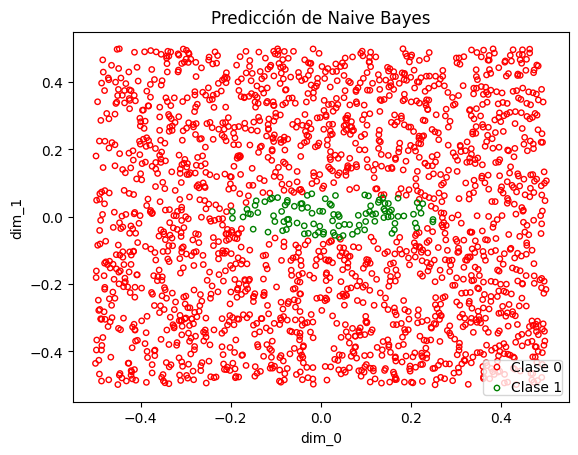

In [58]:
prediction = naive_bayes.predict(X_test)
test_error = zero_one_loss(y_test, prediction)

print(f"Error de ANN fue {test_error}")

idx = np.where(prediction == 0)
plt.scatter(
    X_test.to_numpy()[idx, 0],
    X_test.to_numpy()[idx, 1],
    facecolors='none',
    edgecolors='r',
    label="Clase 0",
    cmap=plt.cm.RdYlBu,
    s=15,
)

idx = np.where(prediction == 1)
plt.scatter(
    X_test.to_numpy()[idx, 0],
    X_test.to_numpy()[idx, 1],
    facecolors='none',
    edgecolors='g',
    label="Clase 1",
    cmap=plt.cm.RdYlBu,
    s=15,
)

plt.xlabel("dim_0")
plt.ylabel("dim_1")
plt.legend(loc="lower right", borderpad=0, handletextpad=0)
plt.title(f'Predicción de Naive Bayes')
plt.show()

### Análisis

## Espirales anidadas

### Entrenamiento

In [59]:
#defino parámetros de la red
epocas_por_entrenamiento=100     #numero de epocas que entrena cada vez
eta=0.1                         #learning rate
alfa=0.9                        #momentum
evaluaciones = 500
N2=20

In [60]:
df_train = espirales(600)
train_target = df_train["class"].to_numpy()
train_data = df_train.drop(columns=["class"]).to_numpy()
X_train, X_val, y_train, y_val = train_test_split(train_data, train_target, test_size = 0.2)

df_test = espirales(2000)
feature_names = list(df_test.columns.values)[:-1]
y_test = df_test["class"].to_numpy()
X_test = df_test.drop(columns=["class"]).to_numpy()

In [61]:
clasif = MLPClassifier(hidden_layer_sizes=(N2,), activation='logistic', solver='sgd', alpha=0.0, batch_size=1, learning_rate='constant', learning_rate_init=eta,momentum=alfa,nesterovs_momentum=False,tol=0.0,warm_start=True,max_iter=epocas_por_entrenamiento)

best_red, error_train, error_val, error_test = entrenar_red(clasif, evaluaciones, X_train, y_train, X_val, y_val, X_test, y_test)

In [62]:
# Naive Bayes
naive_bayes = GaussianNB()
naive_bayes.fit(train_data, train_target)

GaussianNB()

### Gráficas

Error de ANN fue 0.267


C:\Users\Certi\AppData\Local\Temp\ipykernel_1956\561518149.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(
C:\Users\Certi\AppData\Local\Temp\ipykernel_1956\561518149.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


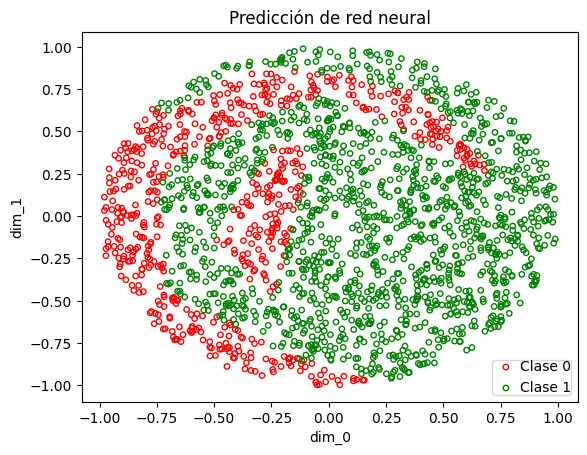

In [63]:
prediction = best_red.predict(X_test)
test_error = zero_one_loss(y_test, prediction)
print(f"Error de ANN fue {test_error}")

idx = np.where(prediction == 0)
plt.scatter(
    X_test[idx, 0],
    X_test[idx, 1],
    facecolors='none',
    edgecolors='r',
    label="Clase 0",
    cmap=plt.cm.RdYlBu,
    s=15,
)

idx = np.where(prediction == 1)
plt.scatter(
    X_test[idx, 0],
    X_test[idx, 1],
    facecolors='none',
    edgecolors='g',
    label="Clase 1",
    cmap=plt.cm.RdYlBu,
    s=15,
)

plt.xlabel("dim_0")
plt.ylabel("dim_1")
plt.legend(loc="lower right", borderpad=0, handletextpad=0)
plt.title(f'Predicción de red neural')
plt.show()

Error de ANN fue 0.4605


C:\Users\Certi\AppData\Local\Temp\ipykernel_1956\2808327386.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


C:\Users\Certi\AppData\Local\Temp\ipykernel_1956\2808327386.py:18: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


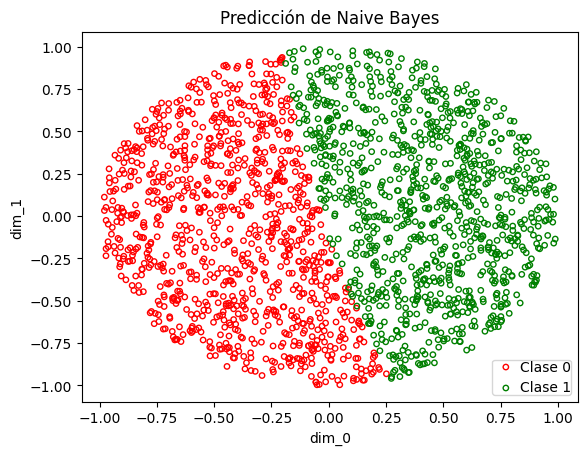

In [64]:
prediction = naive_bayes.predict(X_test)
test_error = zero_one_loss(y_test, prediction)

print(f"Error de ANN fue {test_error}")

idx = np.where(prediction == 0)
plt.scatter(
    X_test[idx, 0],
    X_test[idx, 1],
    facecolors='none',
    edgecolors='r',
    label="Clase 0",
    cmap=plt.cm.RdYlBu,
    s=15,
)

idx = np.where(prediction == 1)
plt.scatter(
    X_test[idx, 0],
    X_test[idx, 1],
    facecolors='none',
    edgecolors='g',
    label="Clase 1",
    cmap=plt.cm.RdYlBu,
    s=15,
)

plt.xlabel("dim_0")
plt.ylabel("dim_1")
plt.legend(loc="lower right", borderpad=0, handletextpad=0)
plt.title(f'Predicción de Naive Bayes')
plt.show()

### Análisis

# Ejercicio 3

In [65]:
def entrenar_naive_bayes_histograma(bins_values, X_train, y_train, X_val, y_val, X_test, y_test):
    best_error = 1.0
    best_clasificador = None
    best_discretizador = None
    error_train = []
    error_test = []
    error_val = []
    for bins in bins_values:
        discretizador = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='uniform')
        clasificador = CategoricalNB(min_categories=bins)
        
        X_train_discretizado = discretizador.fit_transform(X_train)
        X_val_discretizado = discretizador.transform(X_val)
        X_test_discretizado = discretizador.transform(X_test)

        clasificador.fit(X_train_discretizado, y_train)

        P_train = clasificador.predict(X_train_discretizado)
        error_train.append(zero_one_loss(y_train, P_train))

        P_val = clasificador.predict(X_val_discretizado)
        error_val.append(zero_one_loss(y_val, P_val))

        P_test = clasificador.predict(X_test_discretizado)
        error_test.append(zero_one_loss(y_test, P_test))

        if error_val[-1] < best_error:
            best_error = error_val[-1]
            best_clasificador = copy.deepcopy(clasificador)
            best_discretizador = copy.deepcopy(discretizador)

    return best_clasificador, best_discretizador, error_train, error_val, error_test

# Ejercicio 4

## Dos elipses

### Entrenamiento

In [66]:
X_data_aux, y_data_aux = cargar_csv("./data/dos_elipses.data", 2)
X_test, y_test = cargar_csv("./data/dos_elipses.test", 2)

X_data, _, y_data, _ = train_test_split(X_data_aux, y_data_aux, test_size = 0.5)
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size = 0.2)

C:\Users\Certi\AppData\Local\Temp\ipykernel_1956\1536466213.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(path, delim_whitespace=delim_whitespace, header=None)
C:\Users\Certi\AppData\Local\Temp\ipykernel_1956\1536466213.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(path, delim_whitespace=delim_whitespace, header=None)


In [67]:
bins_values = range(2, 100)

best_clasificador, best_discretizador, error_train, error_val, error_test = entrenar_naive_bayes_histograma(bins_values, X_train, y_train, X_val, y_val, X_test, y_test)

### Gráficas

C:\Users\Certi\AppData\Local\Temp\ipykernel_1956\2518268146.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(
C:\Users\Certi\AppData\Local\Temp\ipykernel_1956\2518268146.py:14: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


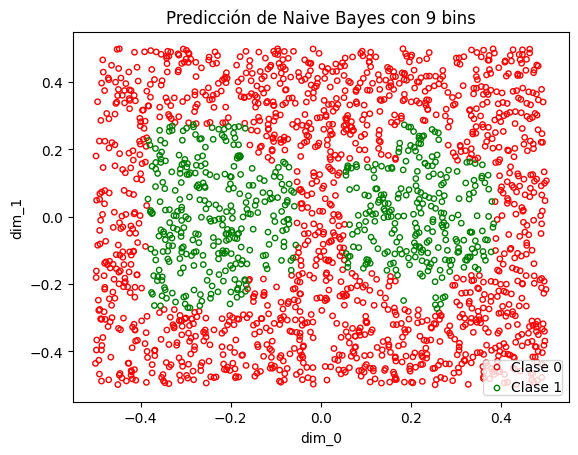

In [68]:
P_test = best_clasificador.predict(best_discretizador.transform(X_test))
idx = np.where(P_test == 0)
plt.scatter(
    X_test.to_numpy()[idx, 0],
    X_test.to_numpy()[idx, 1],
    facecolors='none',
    edgecolors='r',
    label="Clase 0",
    cmap=plt.cm.RdYlBu,
    s=15,
)

idx = np.where(P_test == 1)
plt.scatter(
    X_test.to_numpy()[idx, 0],
    X_test.to_numpy()[idx, 1],
    facecolors='none',
    edgecolors='g',
    label="Clase 1",
    cmap=plt.cm.RdYlBu,
    s=15,
)

plt.xlabel("dim_0")
plt.ylabel("dim_1")
plt.legend(loc="lower right", borderpad=0, handletextpad=0)
plt.title(f'Predicción de Naive Bayes con {best_discretizador.n_bins} bins')
plt.show()

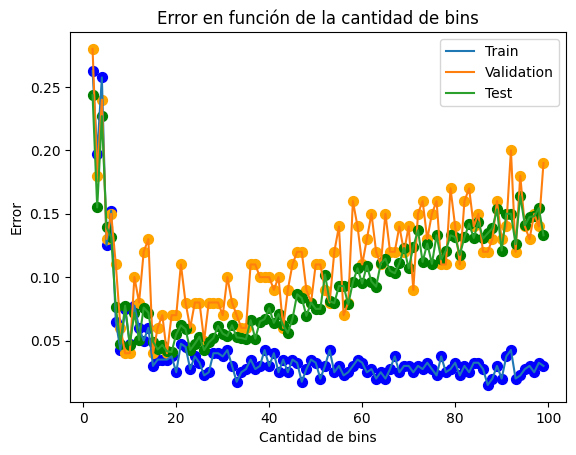

In [69]:
plt.plot(bins_values, error_train, label="Train")
plt.plot(bins_values, error_val, label="Validation")
plt.plot(bins_values, error_test, label="Test")
plt.scatter(bins_values, error_train, color='blue', s=50)  # puntos en azul
plt.scatter(bins_values, error_val, color='orange', s=50)  # puntos en naranja
plt.scatter(bins_values, error_test, color='green', s=50)  # puntos en verde
plt.xlabel("Cantidad de bins")
plt.ylabel("Error")
plt.legend()
plt.title(f'Error en función de la cantidad de bins')
plt.show()

### Análisis

## Espirales anidadas

### Entrenamiento

In [88]:
df_train = espirales(600)
train_target = df_train["class"].to_numpy()
train_data = df_train.drop(columns=["class"]).to_numpy()
X_train, X_val, y_train, y_val = train_test_split(train_data, train_target, test_size = 0.2)

df_test = espirales(2000)
feature_names = list(df_test.columns.values)[:-1]
y_test = df_test["class"].to_numpy()
X_test = df_test.drop(columns=["class"]).to_numpy()

In [89]:
bins_values = range(2, 100)
best_clasificador, best_discretizador, error_train, error_val, error_test = entrenar_naive_bayes_histograma(bins_values, X_train, y_train, X_val, y_val, X_test, y_test)

### Gráficas

C:\Users\Certi\AppData\Local\Temp\ipykernel_1956\2691276217.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(
C:\Users\Certi\AppData\Local\Temp\ipykernel_1956\2691276217.py:14: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


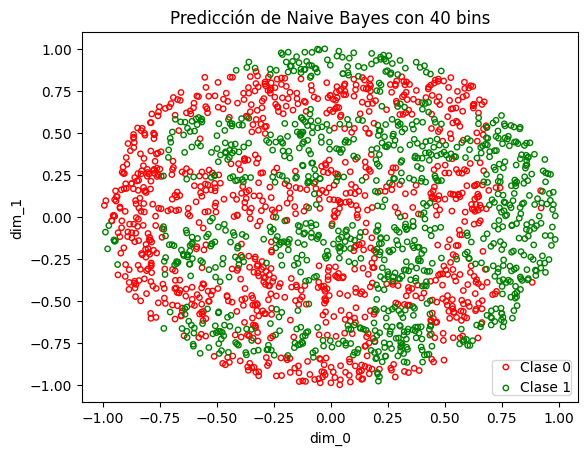

In [90]:
P_test = best_clasificador.predict(best_discretizador.transform(X_test))
idx = np.where(P_test == 0)
plt.scatter(
    X_test[idx, 0],
    X_test[idx, 1],
    facecolors='none',
    edgecolors='r',
    label="Clase 0",
    cmap=plt.cm.RdYlBu,
    s=15,
)

idx = np.where(P_test == 1)
plt.scatter(
    X_test[idx, 0],
    X_test[idx, 1],
    facecolors='none',
    edgecolors='g',
    label="Clase 1",
    cmap=plt.cm.RdYlBu,
    s=15,
)

plt.xlabel("dim_0")
plt.ylabel("dim_1")
plt.legend(loc="lower right", borderpad=0, handletextpad=0)
plt.title(f'Predicción de Naive Bayes con {best_discretizador.n_bins} bins')
plt.show()

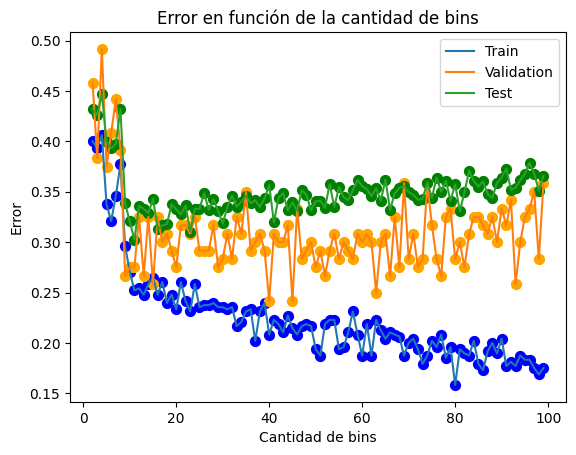

In [91]:
plt.plot(bins_values, error_train, label="Train")
plt.plot(bins_values, error_val, label="Validation")
plt.plot(bins_values, error_test, label="Test")
plt.scatter(bins_values, error_train, color='blue', s=50)  # puntos en azul
plt.scatter(bins_values, error_val, color='orange', s=50)  # puntos en naranja
plt.scatter(bins_values, error_test, color='green', s=50)  # puntos en verde
plt.xlabel("Cantidad de bins")
plt.ylabel("Error")
plt.legend()
plt.title(f'Error en función de la cantidad de bins')
plt.show()

### Análisis

# Ejercicio 5